# Weather Forecast
This code is rough work that plays around with weather dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df_test = pd.read_csv('DailyDelhiClimateTest.csv') 
df_train = pd.read_csv('DailyDelhiClimateTrain.csv')
df = pd.concat([df_test, df_train])
df.head(5)

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [3]:
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d") #Change date to correct format
df['month'] = df['date'].apply(lambda x: str(x.month)) #Create column for month
df['year'] = df['date'].apply(lambda x: str(x.year)) #Create column for year
df['day'] = df['date'].apply(lambda x: str(x.day)) #Create column for day

df.index = df['date'].rename('index') #Index by date
print("Dataframe shape: ", df.shape) #Check size
df.head(5)

,date,meantemp,humidity,wind_speed,meanpressure,month,year,day
index,,,,,,,,
2017-01-01,2017-01-01,15.913043,85.869565,2.743478,59.000000,1,2017,1
2017-01-02,2017-01-02,18.500000,77.222222,2.894444,1018.277778,1,2017,2
2017-01-03,2017-01-03,17.111111,81.888889,4.016667,1018.333333,1,2017,3
2017-01-04,2017-01-04,18.700000,70.050000,4.545000,1015.700000,1,2017,4
2017-01-05,2017-01-05,18.388889,74.944444,3.300000,1014.333333,1,2017,5


<AxesSubplot:xlabel='meantemp'>

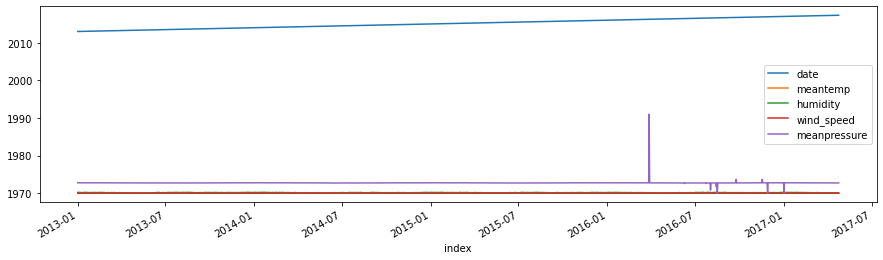

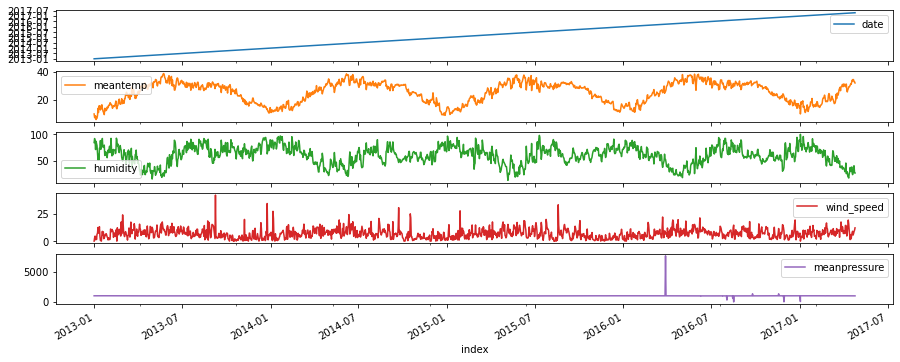

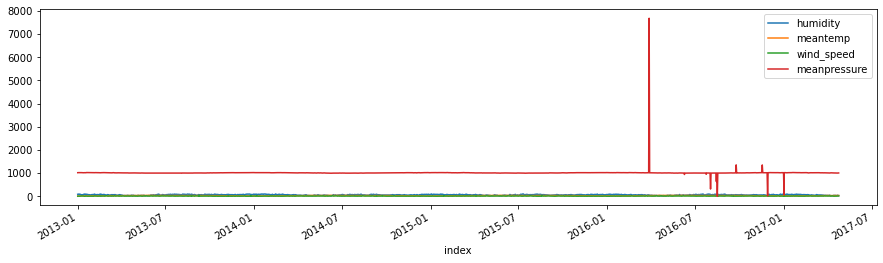

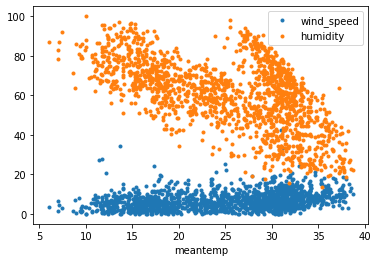

In [5]:
df.plot(figsize=(15,4))
df.plot(subplots=True, figsize=(15,6))
df.plot(y=["humidity", "meantemp",'wind_speed', 'meanpressure'], figsize=(15,4))
df.plot(x="meantemp", y=["wind_speed", "humidity"], style='.')

array([[<AxesSubplot:xlabel='meantemp', ylabel='meantemp'>,
        <AxesSubplot:xlabel='humidity', ylabel='meantemp'>,
        <AxesSubplot:xlabel='wind_speed', ylabel='meantemp'>,
        <AxesSubplot:xlabel='meanpressure', ylabel='meantemp'>],
       [<AxesSubplot:xlabel='meantemp', ylabel='humidity'>,
        <AxesSubplot:xlabel='humidity', ylabel='humidity'>,
        <AxesSubplot:xlabel='wind_speed', ylabel='humidity'>,
        <AxesSubplot:xlabel='meanpressure', ylabel='humidity'>],
       [<AxesSubplot:xlabel='meantemp', ylabel='wind_speed'>,
        <AxesSubplot:xlabel='humidity', ylabel='wind_speed'>,
        <AxesSubplot:xlabel='wind_speed', ylabel='wind_speed'>,
        <AxesSubplot:xlabel='meanpressure', ylabel='wind_speed'>],
       [<AxesSubplot:xlabel='meantemp', ylabel='meanpressure'>,
        <AxesSubplot:xlabel='humidity', ylabel='meanpressure'>,
        <AxesSubplot:xlabel='wind_speed', ylabel='meanpressure'>,
        <AxesSubplot:xlabel='meanpressure', ylabel='meanp

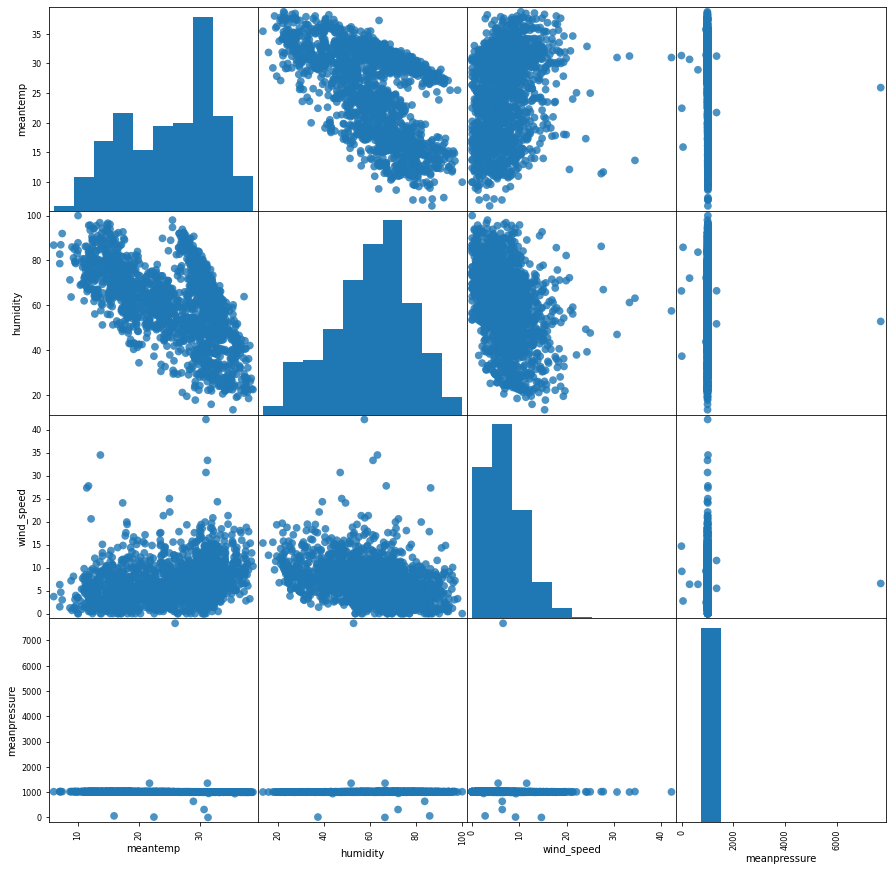

In [6]:
pd.plotting.scatter_matrix(df, marker= 'o', figsize=(15,15), s=60, alpha=.8)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

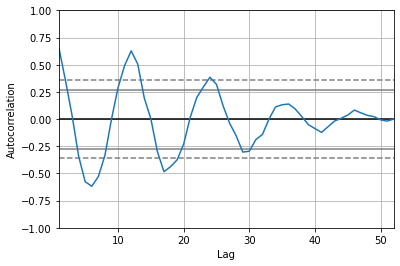

In [13]:
pd.plotting.autocorrelation_plot(df["wind_speed"].resample("1m").median())

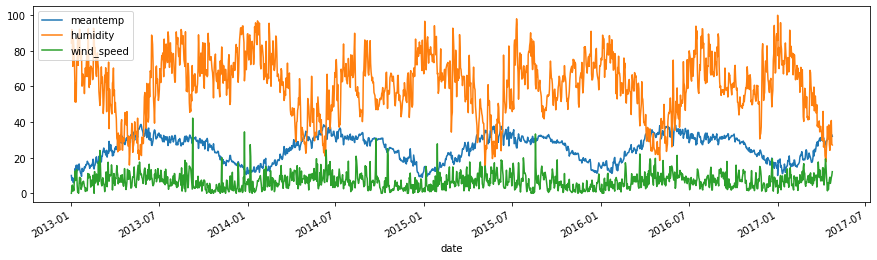

In [28]:
df.plot(y=["meantemp", "humidity", 'wind_speed'], figsize=(15,4));

# Wind speed

## FBProphet

In [ ]:
import fbprophet

# Prophet requires columns ds (Date) and y (value)
df = df.rename(columns={'date': 'ds', 'wind_speed': 'y'})

# Make the prophet model and fit on the data
df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
df_prophet.fit(df)

In [ ]:
# Make a future dataframe for 2 years
df_forecast = df_prophet.make_future_dataframe(periods=365 * 2, freq='D')

# Make predictions
df_forecast = df_prophet.predict(df_forecast)

In [ ]:
df_prophet.plot(df_forecast, xlabel='Date', ylabel='Wind speed')
plt.title('Wind speed forecast')

In [ ]:
df_prophet.changepoints[:10]

In [ ]:
df_prophet.plot_components(df_forecast)

## Different approach

/Users/monseguedesayala/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/seasonal.py:303: UserWarning: Attempting to set identical left == right == 17167.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


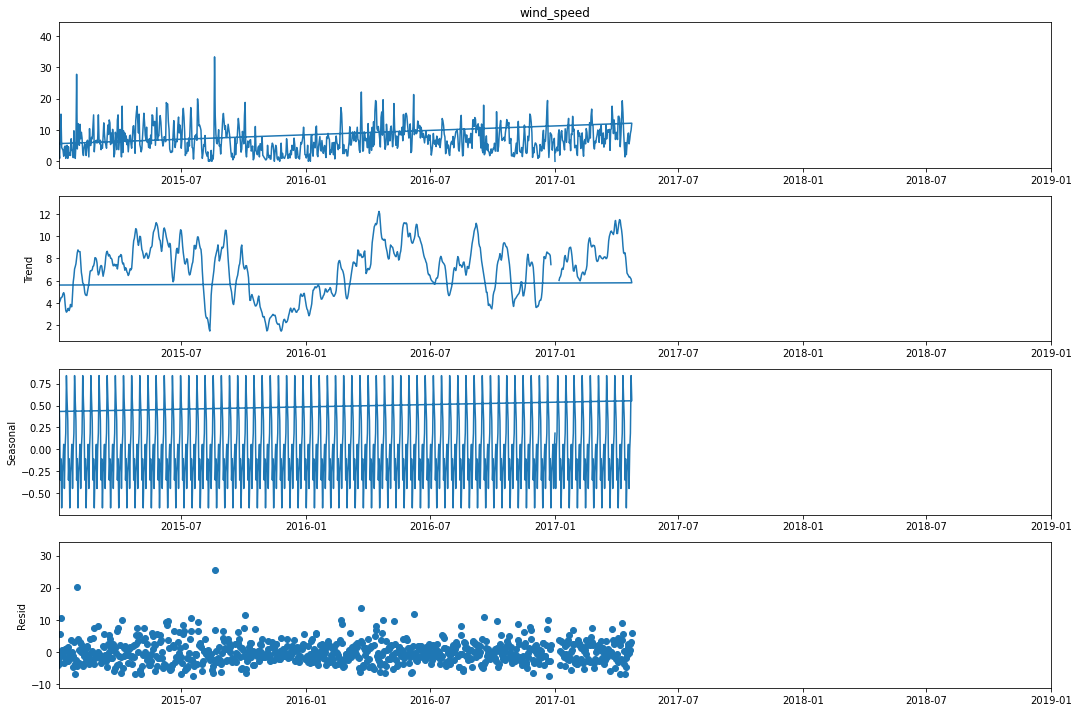

In [29]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

#Graph with trends and seasonality
decomposition = seasonal_decompose(df['wind_speed'], period=12)
plt.rcParams["figure.figsize"] = (15,10)

decomposition.plot()
plt.show()

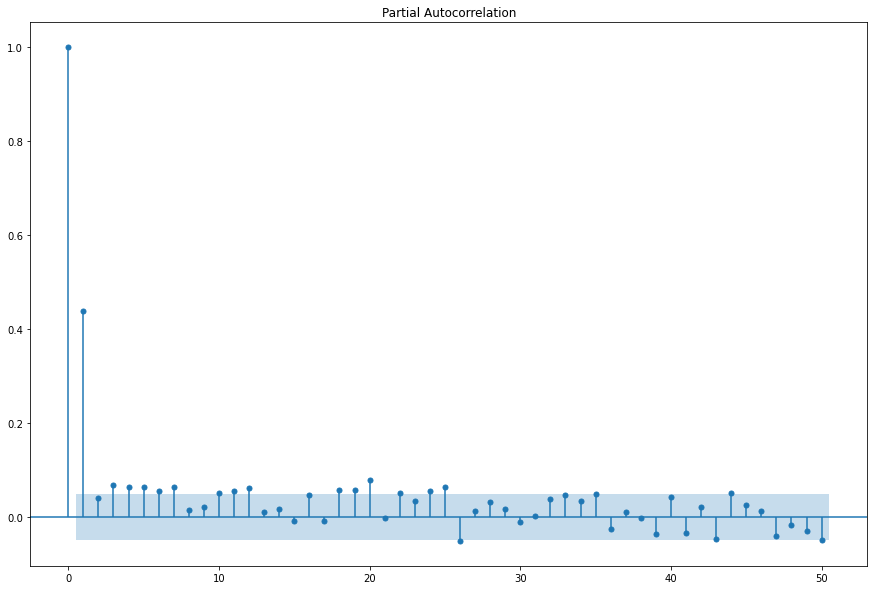

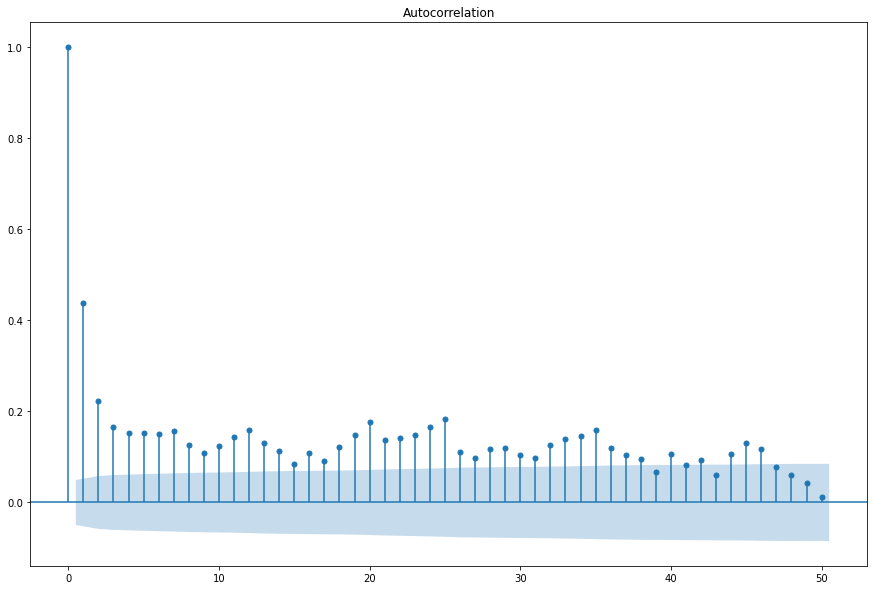

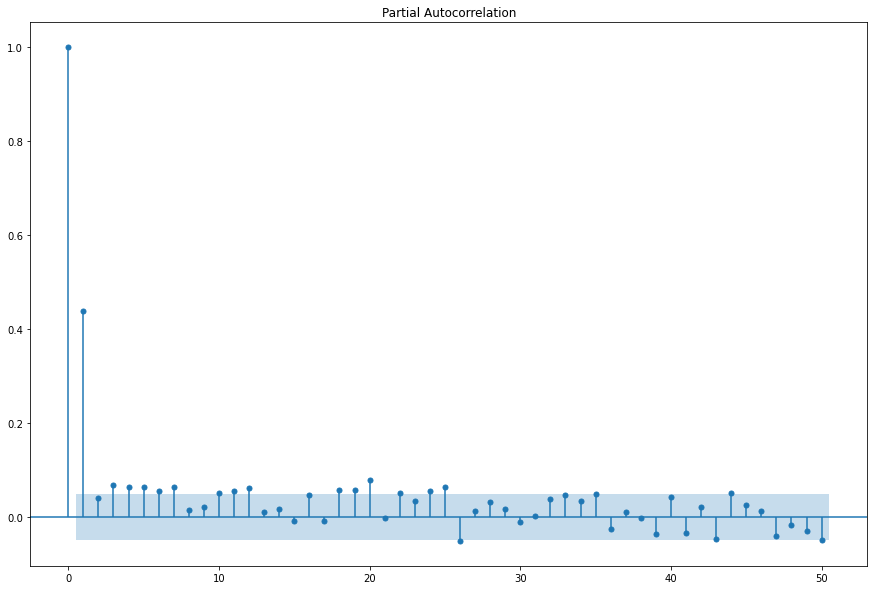

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['wind_speed'], lags=50)
plot_pacf(df['wind_speed'], lags=50)

In [31]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df['wind_speed'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                   -4.050682
p-value                           0.001167
#Lags Used                       24.000000
Number of Observations Used    1551.000000
Critical Value (1%)              -3.434573
Critical Value (5%)              -2.863405
Critical Value (10%)             -2.567763
dtype: float64


## ARIMA

In [ ]:
import pmdarima as pm
model = pm.auto_arima(df['wind_speed'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

In [18]:
import statsmodels.api as sm

mod = sm.tsa.arima.ARIMA(df['wind_speed'].values, order=(1, 0, 12))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1576
Model:                ARIMA(1, 0, 12)   Log Likelihood               -4409.337
Date:                Wed, 23 Jun 2021   AIC                           8848.674
Time:                        16:43:22   BIC                           8929.114
Sample:                             0   HQIC                          8878.567
                               - 1576                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8670      0.663     10.354      0.000       5.567       8.167
ar.L1          0.9830      0.009    111.255      0.000       0.966       1.000
ma.L1         -0.5979      0.019    -31.829      0.0

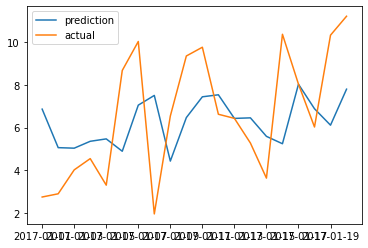

In [26]:
pred = res.predict()
df['prediction'] = pred
df_ = df.head(20)
plt.plot(df_.index, df_.prediction, label='prediction')
plt.plot(df_.index, df_.wind_speed, label='actual')
plt.legend()

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.full(len(df),0.001), y_true))) * 100

In [31]:
mean_absolute_percentage_error(df.wind_speed,df.prediction)

7725.982324526287

In [32]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(df.wind_speed,df.prediction)

2.8478001078769535

In [ ]:
df = df[['date','wind_speed']]
df.head(5)

## tsfresh

In [ ]:
import tsfresh as tsf
from tsfresh.utilities.dataframe_functions import roll_time_series

df_rolled = roll_time_series(df, column_id='date', column_sort="date")

In [ ]:
# Plot prices and moving average
sns.lineplot()